In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
data = pd.read_csv(r'../data/all_wells.csv')
data.head()

,easting,northing,porosity,permeability,Poisson's ratio,Young's Modulus,water saturation,oil saturation,proppant weight (lbs),pump rate (cubic feet/min),...,water 3,water 4,water 5,water 6,water 7,water 8,water 9,water 10,water 11,water 12
0,32600.0,52200.0,0.04,0.006,0.31,1.224949e+07,0.141918,0.858082,1.059118e+06,220.584462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32703.0,52200.0,0.02,0.001,0.31,1.224911e+07,0.141804,0.858196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32807.0,52200.0,0.03,0.002,0.31,1.224864e+07,0.141688,0.858312,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32910.0,52200.0,0.04,0.008,0.31,1.224807e+07,0.141571,0.858429,5.634563e+05,286.379301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33014.0,52200.0,0.03,0.004,0.31,1.224740e+07,0.141452,0.858548,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We scale the easting and northing features to fit the range (-1,1).

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
    
scaled_x = pd.DataFrame(min_max_scaler.fit_transform(data[['easting', 'northing']].values)).dropna()

The method build_datasets is created to scale the data of a feature to the range (-1,1) and then construct a train loader.

In [4]:
def build_datasets(feature, test_size=0.8, random_state=0):
    y = pd.DataFrame(min_max_scaler.fit_transform(data[feature].values.reshape(-1, 1))).dropna()
    train_x, test_x, train_y, test_y = train_test_split(scaled_x, y, test_size=test_size, random_state=random_state)
    
    train = torch.utils.data.TensorDataset(torch.Tensor(np.array(train_x)), torch.Tensor(np.array(train_y)))
    train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
    
    return (train_loader, test_x, test_y)

The following method takes the input of a model, optimizer, our train loader and a number of epochs and returns the corresponding training losses.

In [5]:
def train_model(model, optimizer, train_loader, criterion=nn.SmoothL1Loss(), epochs=1000):
    for e in range(epochs):
        running_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            forward_pass = model(features)
            loss = criterion(forward_pass, labels.type(torch.FloatTensor))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if (e + 1) % (epochs // 10) == 0:
            print("===================== Epoch %d =====================" % (e + 1))
            print("Training loss: %.10f" % (running_loss / len(train_loader)))

We create the following method to return the heat map of a feature with respect to easting and northing.

In [6]:
def plot_feature(model, feature, precision=2000):
    easting = data['easting']
    northing = data['northing']
    grid = np.mgrid[easting.min():easting.max():precision, northing.min():northing.max():precision]
    grid = grid.reshape((2, -1))

    input_array = []

    for i in range(len(grid[0])):
        input_array.append((grid[0][i], grid[1][i]))

    with torch.no_grad():
        features = torch.tensor(np.array(input_array)).float();
        predictions = min_max_scaler.fit_transform(model(features))

        plt.xlabel('easting')
        plt.ylabel('northing')
        plt.scatter(grid[0], grid[1], c=predictions)
        plt.colorbar()

In [7]:
def score_model(model, test_x, test_y): #Returns score
    with torch.no_grad():
        predictions = model(torch.tensor(np.array(test_x)).float())
        print(r2_score(predictions, test_y))

We define the model with ReLU activations and build a feed-forward network. 

In [8]:
model = nn.Sequential(nn.Linear(2, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1),
                     )

train_loader, test_x, test_y = build_datasets('porosity')

In [9]:
train_model(model, optim.SGD(model.parameters(), lr=0.03), train_loader)

===================== Epoch 100 =====================
Training loss: 0.0078861650
===================== Epoch 200 =====================
Training loss: 0.0072983540
===================== Epoch 300 =====================
Training loss: 0.0069014866
===================== Epoch 400 =====================
Training loss: 0.0065852579
===================== Epoch 500 =====================
Training loss: 0.0063894839
===================== Epoch 600 =====================
Training loss: 0.0062518639
===================== Epoch 700 =====================
Training loss: 0.0061705658
===================== Epoch 800 =====================
Training loss: 0.0061335595
===================== Epoch 900 =====================
Training loss: 0.0061217246
===================== Epoch 1000 =====================
Training loss: 0.0060668472


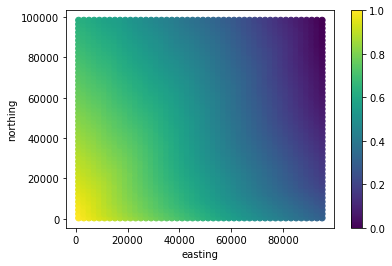

In [10]:
plot_feature(model, 'porosity')

In [11]:
score_model(model, test_x, test_y)

0.5916648254814793
